# Machine Learning on Genomic Data: Colon Cancer Dataset (Alon et al., 1999)

In this notebook, we explore how to apply **Machine Learning (ML) techniques** to real **gene expression** data, using the classic dataset from **Alon et al. (1999)** — one of the first studies on the use of transcriptomic profiling to distinguish between **tumor** and **normal** tissues of the human colon.

The objective is to demonstrate, step by step, how to transition from raw laboratory data to an interpretable predictive model in the biomedical field.

## Notebook Workflow

1. **Introduction and Dataset Description**  
   – biological context and structure of gene expression data.  

2. **Loading and Exploration (EDA)**  
   – preliminary analysis of distributions, correlations, and classes.  

3. **Data Preprocessing**  
   – separation of *train/test*, balancing, and standardization of features.  

4. **Training Supervised Models**  
   – Logistic Regression, Decision Tree, Random Forest, XGBoost.  

5. **Performance Evaluation**  
   – key medical metrics: *Accuracy, Precision, Recall, F1-score*.  

6. **Model Interpretability**  
   – *Feature Importance*, *SHAP values*, and *LIME* to analyze relevant genes.  

7. **Conclusions and Perspectives**  
   – limitations of traditional models and introduction to *Deep Learning* for genomic data.

*Educational Objective:* to understand how to build, evaluate, and interpret a **genomic classification** model capable of distinguishing tumor profiles from normal ones, emphasizing both the predictive and biological-explanatory aspects.

In [1]:
# Environment Setup

# !pip install numpy pandas matplotlib seaborn scikit-learn -q rpy2 xgboost shap lime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, conversion

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings("ignore")

print("Environment ready — ML libraries, XGBoost, SHAP, and LIME installed and imported.")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Environment ready — ML libraries, XGBoost, SHAP, and LIME installed and imported.


## 1. Introduction and Dataset Description

##### Description of the Colon Cancer Dataset (Alon et al., 1999):
- A total of 62 colon tissue samples:  
  - 40 **tumor** (class = 2)  
  - 22 **normal** (class = 1)  
- **2000 genes** measured for each sample (feature).  
- **High-dimensional dataset** → many more variables (genes) than observations (patients).  
- Collected from the [Princeton Oncology Microarray Project](http://genomics-pubs.princeton.edu/oncology/affydata/index.html).  
- Published in:  
  **Alon, U. et al. (1999)** – *Broad patterns of gene expression revealed by clustering analysis of tumor and normal colon tissues probed by oligonucleotide arrays*.  
  *PNAS*, 96(12), 6745–6750.  
- Available in **R** via the [`plsgenomics`](https://cran.r-project.org/package=plsgenomics) package, dataset `Colon`.


##### Loading in Python

The original dataset was imported from R using the `rpy2` package and converted into a **pandas DataFrame**:  
this allows for work in Python while maintaining the original structure (62 × 2000).  

> Educational Note: this conversion step is not part of the course objective —  
> it is merely a technical step to obtain the data in a usable format with *scikit-learn*.

In [2]:
# Activate the extension that allows the use of R cells in a Python notebook.
%load_ext rpy2.ipython

In [3]:
%%R
if (!require("plsgenomics")) install.packages("plsgenomics", repos="http://cran.us.r-project.org")
library(plsgenomics)

data("Colon", package = "plsgenomics")

cat("Colon Cancer dataset (Alon 1999) loaded in R\n")

X <- Colon$X
Y <- Colon$Y
df <- as.data.frame(X)
df$class <- Y

Colon Cancer dataset (Alon 1999) loaded in R


Loading required package: plsgenomics
For any news related to the 'plsgenomics' package (update, corrected bugs), please check https://github.com/gdurif/plsgenomics


In [4]:
# Convert the R DataFrame to pandas
with conversion.localconverter(ro.default_converter + pandas2ri.converter):
    df = conversion.rpy2py(ro.globalenv['df'])

# Convert 'class' column to integer type
df['class'] = df['class'].astype('int64')

print("Dataset successfully converted to pandas DataFrame.")

Dataset successfully converted to pandas DataFrame.


From this point onward, we will work exclusively with the pre-prepared **pandas DataFrame**:

- 62 rows → patient samples  
- 2000 columns → genes  
- column `class` → sample label (Normal: `1`, Tumor: `2`)

In [5]:
# Initial Exploration of the Dataset
# Dataset dimensions (rows, columns)
print("Dimensioni del dataset:", df.shape)

# We display the first 5 rows to observe the structure of the data.
display(df.head())

Dimensioni del dataset: (62, 2001)


,1,2,3,4,5,6,7,8,9,10,...,1992,1993,1994,1995,1996,1997,1998,1999,2000,class
1,8589.4163,5468.2409,4263.4075,4064.9357,1997.8929,5282.3250,2169.7200,2773.4212,7526.3862,4607.6762,...,67.56125,259.91250,138.89875,88.23250,39.667857,67.82875,75.67750,83.52250,28.70125,2
2,9164.2537,6719.5295,4883.4487,3718.1589,2015.2214,5569.9071,3849.0588,2793.3875,7017.7338,4802.2524,...,92.23875,96.27625,150.59000,82.23750,85.033333,152.19500,186.56750,44.47250,16.77375,1
3,3825.7050,6970.3614,5369.9688,4705.6500,1166.5536,1572.1679,1325.4025,1472.2587,3296.9512,2786.5821,...,82.71500,31.10250,193.92000,76.97250,224.620240,31.22500,42.65625,16.09250,15.15625,2
4,6246.4487,7823.5341,5955.8350,3975.5643,2002.6131,2130.5429,1531.1425,1714.6312,3869.7850,4989.4071,...,41.68375,5.92500,183.00625,74.52875,67.710714,48.33875,42.52000,49.98250,16.08500,1
5,3230.3287,3694.4500,3400.7400,3463.5857,2181.4202,2922.7821,2069.2463,2948.5750,3303.3712,3109.4131,...,76.60375,161.35000,61.70125,54.56375,223.359520,73.09875,57.59875,7.48875,31.81250,2


In [6]:
# Target column (classes to predict)
df['class'].head()

1    2
2    1
3    2
4    1
5    2
Name: class, dtype: int64

In [7]:
# Importing the dataset with pandas
# Option 1 – Reading from a CSV file# The provided text is a code snippet in Python, specifically using the Pandas library to read a CSV file. Here is the translation into fluent, clear, academic English:

# df = pd.read_csv("C:/Users/demo_user/Documents/colon_Alon_1999_62x2000.csv")

# This line of code utilizes the Pandas library to import data from a CSV file located at the specified path on the user's system. The resulting data is stored in the variable `df`.
# Option 2 – Reading from Excel file (.xlsx or .xls)# The provided text is a code snippet in Python that reads an Excel file using the Pandas library. Here is the translation into fluent, clear, academic English:

# df = pd.read_excel("C:/Users/demo_user/Documents/colon_Alon_1999_62x2000.xlsx")

# This line of code imports data from an Excel file located at the specified path into a Pandas DataFrame named `df`.
# Note:# Both functions read the dataset into a pandas DataFrame.# It is also possible to specify the sheet to read from the Excel file with: sheet_name="Foglio1"

## 2. Initial Exploration of the Dataset

In this section, we analyze the **structure and characteristics of the genomic dataset** before training the Machine Learning models.

##### Objectives:
1. **Verify the distribution of classes** → how many samples are *Normal* and how many are *Tumor*.  
2. **Convert the labels** into binary format (0 = Normal, 1 = Tumor), which is more suitable for ML models.  
3. **Examine the descriptive statistics** of the gene expression variables (mean, standard deviation, range).  
4. **Visualize the correlations** among the top 50 features → this helps us understand if certain genes behave similarly (*co-expression* or common pathways).

These steps are essential for understanding the quality of the data and identifying biological patterns prior to predictive analysis.

In [8]:
# Let's examine the distribution of classes in the dataset.
# This tells us how many patients are Normal (class=1) and how many are Tumoral (class=2).
print("Class distribution (original labels):")
print(df['class'].value_counts())

Class distribution (original labels):
class
2    40
1    22
Name: count, dtype: int64


In [9]:
# Convert the target variable into binary numeric values:
# - 1 (Normal) → 0
# - 2 (Tumor) → 1
df['class'] = df['class'].map({1:0, 2:1})
df['class'].head()

1    1
2    0
3    1
4    0
5    1
Name: class, dtype: int64

In [10]:
# Descriptive statistics of the variables (gene expression)
# For simplicity, let us consider only the first 10 features.
# - count = number of values
# - mean = mean# - std = standard deviation
# - min, max, quartiles = distribution of values
print("\nDescriptive statistics (first 10 features):")
print(df.drop(columns=['class']).describe().T.head(10))


Descriptive statistics (first 10 features):
    count         mean          std         min          25%         50%  \
1    62.0  7015.786710  3092.970584  1914.67750  4877.364700  6274.61250   
2    62.0  4966.960015  2188.890480  1383.48860  3408.951150  4738.28070   
3    62.0  4094.727879  1818.080939  1269.64870  2763.725900  3890.33810   
4    62.0  3987.789284  2019.086903  1186.03040  2648.942875  3451.49820   
5    62.0  2937.126113  1356.932887  1166.55360  1890.857125  2666.07560   
6    62.0  4705.119302  2400.848112  1087.75000  2843.368775  4416.61785   
7    62.0  3588.800323  1872.106095  1062.69750  2112.952150  3438.18000   
8    62.0  2872.288631  1122.365448  1026.47750  2050.814025  2844.96065   
9    62.0  4680.191160  2417.239217   995.79000  2971.792775  4088.73560   
10   62.0  4039.661953  2018.044248   974.81548  2797.992525  3823.01790   

            75%         max  
1   8712.283175  14876.4070  
2   6455.843200  10152.2730  
3   5008.993750   8605.0438 

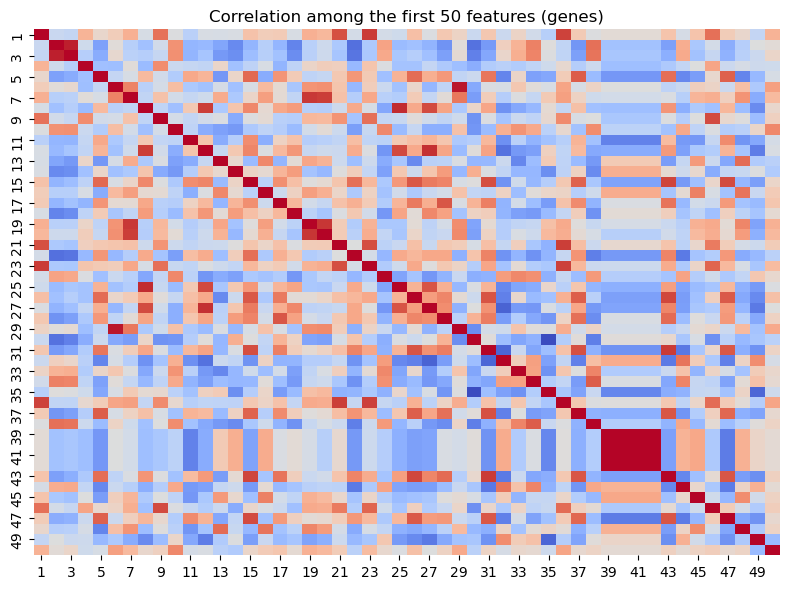

In [11]:
# We visualize a heatmap of the correlations among the top 50 features.
# This helps to understand if there are genes that tend to "move together."
# (strong correlations may indicate similar biological pathways)
plt.figure(figsize=(8,6))
sns.heatmap(
    df.iloc[:, :50].corr(),
    cmap="coolwarm",
    cbar=False
)
plt.title("Correlation among the first 50 features (genes)", fontsize=12)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Before training the Machine Learning models, it is essential to properly prepare the dataset through the following main steps:

1. **Separation of Variables:**
   - **X:** contains the gene expression values (features).  
   - **y:** contains the binary label (0 = Normal, 1 = Tumor).

2. **Dataset Splitting:**
   - **Training set (80%)** → used to train the models.  
   - **Test set (20%)** → used to evaluate the generalization capability.  
   - The option `stratify=y` maintains the same class proportions (Normal/Tumor) in both sets.

3. **Feature Normalization:**
   - We apply a **StandardScaler** to bring all variables onto a similar scale (mean = 0, standard deviation = 1).  
   - This is important because many models (e.g., *Logistic Regression, SVM, Neural Networks*) are sensitive to the scale of the data.

These steps ensure that the training of the models is stable, comparable, and statistically sound.

In [12]:
# We separate the features (X) from the target (y).
# - X contains the expression values of the genes (all columns except 'class')
# - $y$ contains the binary label (0 = Normal, 1 = Tumor)
X = df.drop(columns=['class'])
y = df['class']

In [13]:
# We divide the dataset into a training set and a test set.
# The parameter `test_size=0.2` means that 20% of the data (approximately 12 patients) is allocated to the test set.
# The parameter `stratify=y` is used to maintain the proportion of classes (Normal/Tumor) in both sets.
# The parameter `random_state=42` ensures that the division is reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# We print the dimensions of the two sets.
print("Training set dimensions:", X_train.shape)
print("Test set dimensions:", X_test.shape)    

Training set dimensions: (49, 2000)
Test set dimensions: (13, 2000)


In [14]:
# Let's normalize the data (many models perform better on scaled data).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## 4. Training of Supervised Models

In this section, we train and compare **four classification models**:

- **Logistic Regression** → reference linear model.  
- **Decision Tree** → hierarchical model based on rules.  
- **Random Forest** → ensemble of trees for greater stability and accuracy.  
- **XGBoost** → advanced model based on boosting, widely used in bioinformatics.

For each model:
1. We train it on the training set.  
2. We evaluate the predictions on the test set.  
3. We calculate the main metrics:  
   - **Accuracy:** overall correctness.  
   - **Precision:** reliability of positive predictions.  
   - **Recall:** ability to identify true positives.  
   - **F1-score:** balance between precision and recall.  
4. We visualize the **confusion matrix**, which shows the classification errors.

The goal is to understand **which model generalizes best** on genomic data.

In [15]:
# Let's define the baseline models to be compared.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(max_depth=5, eval_metric='logloss', random_state=42)
}


Logistic Regression
Accuracy: 0.615
Precision: 0.667 | Recall: 0.750 | F1: 0.706

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



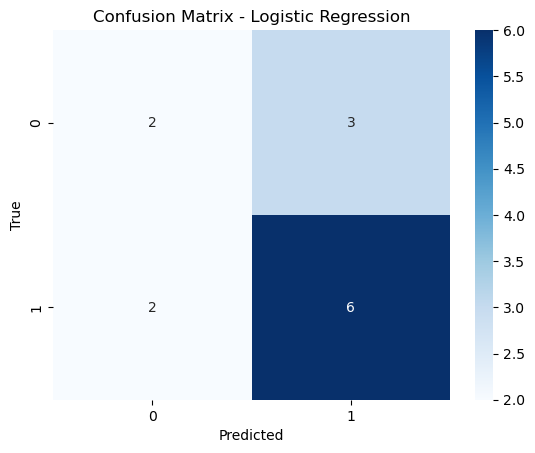


Decision Tree
Accuracy: 0.615
Precision: 0.714 | Recall: 0.625 | F1: 0.667

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.71      0.62      0.67         8

    accuracy                           0.62        13
   macro avg       0.61      0.61      0.61        13
weighted avg       0.63      0.62      0.62        13



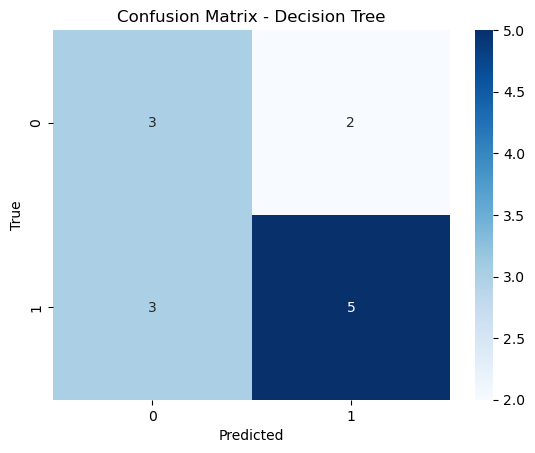


Random Forest
Accuracy: 0.615
Precision: 0.667 | Recall: 0.750 | F1: 0.706

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.67      0.75      0.71         8

    accuracy                           0.62        13
   macro avg       0.58      0.57      0.58        13
weighted avg       0.60      0.62      0.61        13



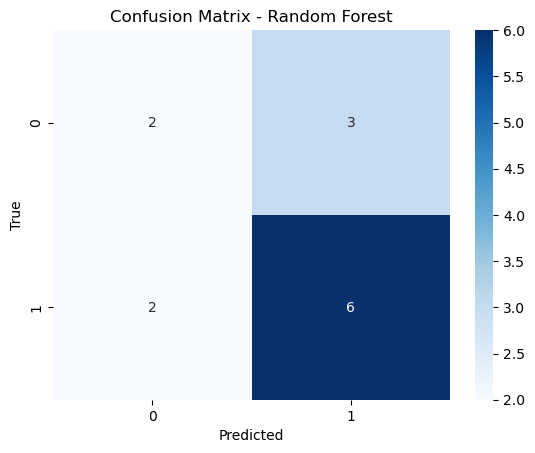


XGBoost
Accuracy: 0.692
Precision: 0.750 | Recall: 0.750 | F1: 0.750

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.75      0.75         8

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13



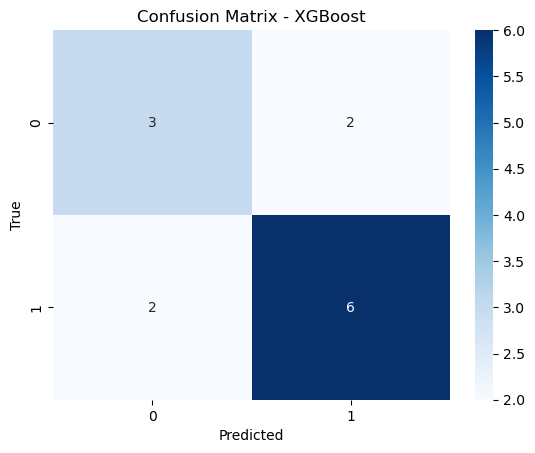

In [16]:
results = []
best_models = {}

for name, model in models.items():
    print(f"\n==============================\n{name}\n==============================")

    # Training
    model.fit(X_train_scaled, y_train)
    best_models[name] = model

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Main metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## 5. Performance Evaluation

After training, we compare the performance of the various classification models.

##### Objectives:
1. **Summarize the numerical results** (Accuracy, Precision, Recall, F1-score) in a comparative table.  
2. **Graphically visualize** the metrics to quickly identify the most performant model.  

##### Key Metrics:
- **Accuracy:** the total proportion of correct predictions.  
- **Precision:** the reliability of positive predictions (few false positives).  
- **Recall (Sensitivity):** the ability to identify true positive cases (few false negatives).  
- **F1-score:** the harmonic mean of Precision and Recall — useful in biomedical contexts with imbalanced classes.  

In a genomic or clinical context, **Precision** and **Recall** are often more important than Accuracy alone,  
because a classification error (false negative or false positive) can have significant biological or clinical impacts.

In [17]:
# Summary of Model Performance
# Let's create a DataFrame with the calculated metrics.
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("Final model results:")
display(results_df)

Final model results:


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.615385,0.666667,0.750,0.705882
1,Decision Tree,0.615385,0.714286,0.625,0.666667
2,Random Forest,0.615385,0.666667,0.750,0.705882
3,XGBoost,0.692308,0.750000,0.750,0.750000


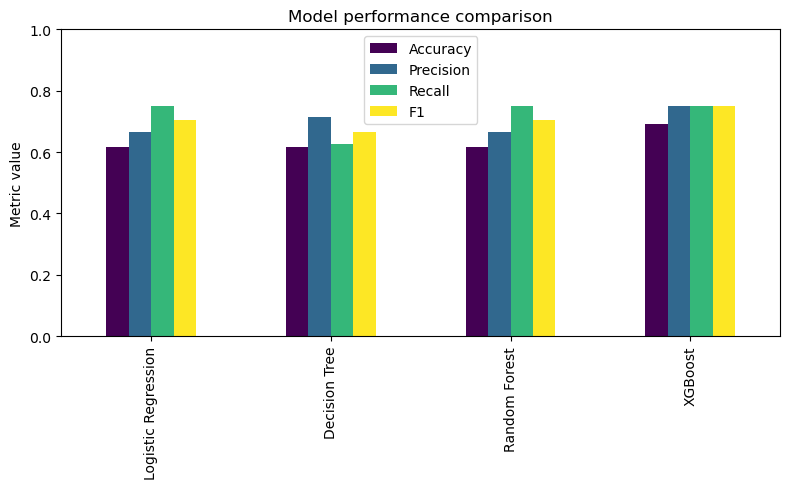

In [18]:
# Comparative Graph of the Metrics
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]].plot(
    kind="bar", figsize=(8,5), ylim=(0,1), colormap="viridis"
)

plt.title("Model performance comparison", fontsize=12)
plt.ylabel("Metric value")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 6. Interpretability of Models

After training, we analyze **which genes have most influenced the decisions** of the various models:

- **Logistic Regression:** provides a *directional* importance → positive coefficients increase the probability of *Tumor*, while negative ones decrease it.  
- **Random Forest:** provides a *non-directional* importance → it only measures how much each gene helps to distinguish the classes.  
- **XGBoost + SHAP:** combines predictive power and global interpretability, showing *how* and *to what extent* each gene influences the outcome.  
- **LIME:** provides *local* explanations → it explains why the model made a certain decision for *a single patient*.

### Model Interpretation: Most Influential Features

**Logistic Regression** is an interpretable linear model.  
Each coefficient $\beta_j$ represents **how much the log-odds** of the positive class (*Tumor*) changes when the feature $x_j$ increases by one unit, while keeping the other variables constant.

- **Positive coefficient (+)** → the gene increases the *log-odds* (and thus the estimated probability) of *Tumor*.  
- **Negative coefficient (−)** → the gene decreases the *log-odds*, favoring the *Normal* class.  
- The absolute value $\beta_j$ indicates the **strength of the effect** on the model.  

In other words, the features with the largest coefficients (in absolute value) are those that most significantly influence the model's decision.

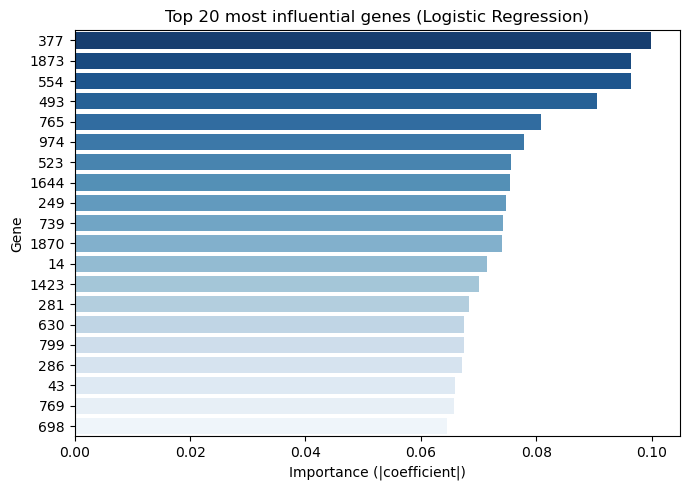

In [19]:
# Feature Importance (Logistic Regression)
log_model = best_models["Logistic Regression"]

# Model coefficients = feature importance
coefs = pd.Series(log_model.coef_[0], index=X.columns)

# Top 20 features by absolute importance
top_coefs = coefs.abs().sort_values(ascending=False).head(20)

# Graph
plt.figure(figsize=(7,5))
sns.barplot(x=top_coefs.values, y=top_coefs.index, palette="Blues_r")
plt.title("Top 20 most influential genes (Logistic Regression)")
plt.xlabel("Importance (|coefficient|)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


### Model Interpretation: Feature Importance (Random Forest)

The **Random Forest** assigns a **predictive importance** score to each variable,  
which indicates *how much the gene contributes to distinguishing between Normal and Tumor samples*.

- Higher values → the gene is more useful for classification.  
- The importance is **non-directional**: it does not indicate whether the gene increases or decreases the probability of cancer,  
  but only **how informative** it is for the decision.

Let us visualize the 20 most important features according to the Random Forest.

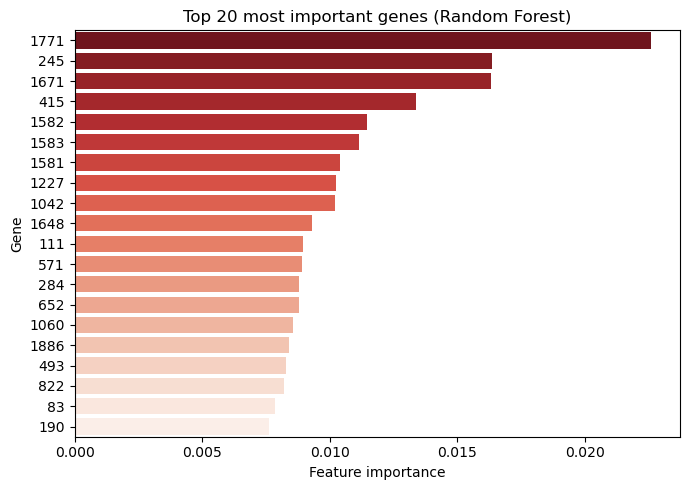

In [20]:
# Feature Importance (Random Forest)
rf_model = best_models["Random Forest"]

# Importance of Features (Non-Directional)
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Graph
plt.figure(figsize=(7,5))
sns.barplot(x=top_features.values, y=top_features.index, palette="Reds_r")
plt.title("Top 20 most important genes (Random Forest)")
plt.xlabel("Feature importance")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


The graph displays the **20 most important genes** according to the Random Forest.  
- Importance measures **how much each gene contributes to reducing the average impurity** in the decision nodes.  
- Higher values indicate that the feature has been used more frequently and effectively to distinguish *Tumor* vs *Normal*.  
- However, it **does not indicate the direction of the effect** (i.e., whether the gene is more expressed in tumor samples or normal samples).

The Random Forest provides a **global and non-directional** measure of importance, useful for identifying the **most discriminative genes** but not for understanding the direction of their biological influence.

### Interpretation of the XGBoost Model with SHAP

**SHAP** values (*SHapley Additive exPlanations*) allow us to understand **how much each gene contributes** to the prediction of the XGBoost model, both in terms of **importance** and **direction of effect**.

- Each point represents a sample (patient).  
- The color indicates the gene value (blue = low, red = high).  
- The horizontal position shows whether the gene increases or decreases the probability of *Tumor*.

This approach is widely used in **predictive genomics** because it combines the power of the model (XGBoost) with the **transparency** of biological interpretation.

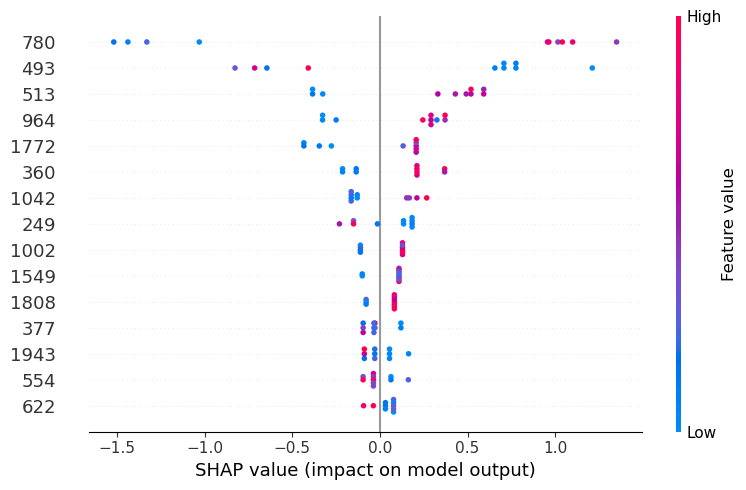

In [21]:
# Reconstructing the DataFrame after scaling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

#  Selezioniamo un piccolo sottoinsieme per SHAP (10 campioni)
X_small = X_test_scaled.sample(10, random_state=42)

# We use TreeExplainer for efficiency.
explainer = shap.TreeExplainer(best_models["XGBoost"])

# Let's calculate SHAP values (much faster and more stable)
shap_values = explainer.shap_values(X_small)

# We visualize a summary plot with a few features.
shap.summary_plot(shap_values, X_small, plot_size=(8,5), max_display=15)


The graph displays the **SHAP values** calculated for each gene in the XGBoost model.  
- Each point represents a patient.  
- The horizontal axis indicates **how much that feature shifts the prediction** towards *Tumor* (→) or *Normal* (←).  
- The color denotes the **value of the feature** (red = high, blue = low).

SHAP provides a **global and directional** explanation:  
- Genes with a positive SHAP value → increase the probability of *Tumor*.  
- Genes with a negative SHAP value → decrease the probability of *Tumor* (favoring *Normal*).

This approach is particularly useful in genomics because it shows **both the importance and the direction of the effect** of each gene on the model.

### Local Interpretation with LIME (XGBoost)

**LIME** (*Local Interpretable Model-agnostic Explanations*) explains **a single prediction**:  
it shows *which genes* influenced the model's decision for *a specific patient*.

- Each feature receives a weight → indicating how much it pushed the decision towards *Tumor* or *Normal*.  
- The graph displays the approximated local rules (e.g., “geneX > threshold → more Tumor”).  
- It is a useful tool in the medical field, as it helps to **discuss predictions on a case-by-case basis**.

**SHAP** explains *globally* (all patients), while **LIME** explains *locally* (one patient at a time).

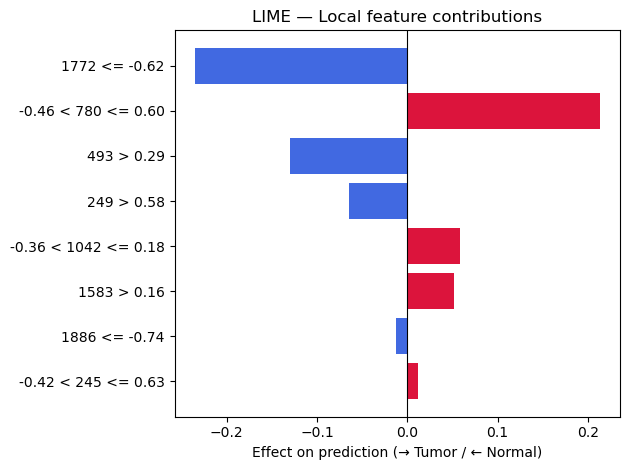

In [22]:
# We select the 30 most important features.
rf = best_models["Random Forest"]
top30 = pd.Series(rf.feature_importances_, index=X.columns).nlargest(30).index

# We reduce the dataset to the top 30 features.
Xtr, Xte = X_train_scaled[top30], X_test_scaled[top30]

# We train a small XGBoost (lighter and more interpretable)
xgb_small = XGBClassifier(eval_metric="logloss", random_state=42).fit(Xtr, y_train)

# Let's create the LIME explainer.
explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(Xtr), feature_names=top30, class_names=["Normal", "Tumor"], mode="classification"
)

# We explain a patient from the test set.
exp = explainer.explain_instance(Xte.iloc[0].values, xgb_small.predict_proba, num_features=8)

# Static Graph of Local Contributions
features, weights = zip(*exp.as_list())
colors = ['crimson' if w > 0 else 'royalblue' for w in weights]

plt.barh(features, weights, color=colors)
plt.axvline(0, color='k', lw=0.8)
plt.gca().invert_yaxis()
plt.title("LIME — Local feature contributions", fontsize=12)
plt.xlabel("Effect on prediction (→ Tumor / ← Normal)")
plt.tight_layout()
plt.show()


The graph illustrates **how the selected features have influenced the prediction** for a single patient.  
- The **red bars** push the prediction towards *Tumor*.  
- The **blue bars** push the prediction towards *Normal*.  
- The length of the bar indicates **how strong the local effect** of that feature was on the model's decision.

In summary:  
LIME provides a **local explanation**, showing *why* the model classified *that patient* as Tumor or Normal.  
It is a useful tool for understanding **individual decisions**, complementing SHAP, which instead offers a **global view**.

## 7. Conclusions and Perspectives

In this notebook, we have:
- Analyzed real genomic data (Colon Cancer, Alon 1999)
- Trained classical Machine Learning models
- Compared performance using various metrics
- Utilized interpretability tools (feature importance, SHAP, LIME)

### Limitations:
- Very small dataset (62 samples) → risk of overfitting.  
- High-dimensional data (2000 variables) → it would be beneficial to apply **feature selection** or **dimensionality reduction**.  

### Next Steps:
Classical Machine Learning has limitations when dealing with biological big data.  
In the next notebook, we will explore how **Deep Learning** can handle much larger and more complex genomic datasets.